In [1]:
import geopandas as gpd
import descartes
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime
from collections import defaultdict
import numpy as np
import contextily as ctx

Read in shapefiles for census tracts (`atx_ct`) and elementary school catchments (`es_shp`):

In [2]:
data_dir = '../../data/'
atx_ct_shp = gpd.read_file(os.path.join(data_dir, '2020_texas_census_tracts/2020_texas_census_tracts.shp'))
es_shp = gpd.read_file(os.path.join(data_dir, 'aisd_shapefiles/20_21_elem_updt_v2.shp'))

Ensure coordinate reference systems (CRS) match.

In [3]:
atx_ct_shp.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [4]:
es_shp.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

They match, but optionally we can change them to use the same CRS as Open Street Maps:

### Visualize Shapefiles
Just to get an idea of what we're looking at.

In [14]:
atx_shp_osm = atx_ct_shp.to_crs({'init': 'EPSG:3857'})
es_shp_osm = es_shp.to_crs({'init': 'EPSG:3857'})

/Users/TASethanho/anaconda3/envs/geopandas/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

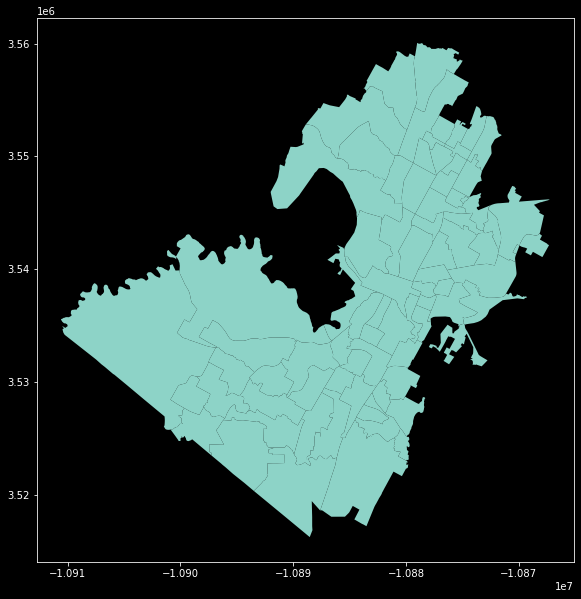

In [13]:
es_shp_osm.plot(figsize=(15, 10))

Calculate the area within each polygon:

In [6]:
es_shp_osm['es_area'] = es_shp_osm.area
atx_shp_osm['cbg_area'] = atx_shp_osm.area

Overlay the two polygons:

In [7]:
es_atx = gpd.overlay(atx_shp_osm, es_shp_osm, how='intersection')

Calculate overlap area and percent overlap:

In [8]:
es_atx['overlap_area'] = es_atx.area
# what percent of an elementary catchment corresponds to the underlying CBG?
es_atx['pct_overlap'] = (es_atx['overlap_area'] / es_atx['cbg_area']) * 100

Grab only the columns of interest to save as a CSV (this will ultimately be further transformed into something like `travel.csv` from the toy contact partitioning model):

In [9]:
overlaps = es_atx[['GEOID', 'ISD', 'CAMPUS', 'SCHL_YEAR', 'pct_overlap']]

Add an age level indicator column:

In [10]:
overlaps['level'] = 'elementary'

<ipython-input-10-e32dde511769>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overlaps['level'] = 'elementary'


Write to file:

In [11]:
overlaps.to_csv('AISD_elem_census_tract_overlaps.csv')